<a href="https://colab.research.google.com/github/choyunjae123/lecture_machineLearning/blob/master/19_5_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
# kaggle의 username을 입력
os.environ['KAGGLE_USERNAME'] = 'yunjaecho1'
# kaggle의 key를 입력 (token값)
os.environ['KAGGLE_KEY'] = '8f9e71f399390930859cd156dafb12c1'
# 이후, 데이터셋 다운로드 시 정식적인 이용에 대한 접근을 알림.

In [3]:
# 데이터셋의 다운로드
!kaggle datasets download -d tongpython/cat-and-dog

100% 217M/218M [00:01<00:00, 180MB/s]
100% 218M/218M [00:01<00:00, 189MB/s]


In [4]:
!unzip -q cat-and-dog.zip

In [5]:
# 필요한 모듈의 import
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
# gpu 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
data_transforms = {
    'train': transforms.Compose([ # 학습군. 다양한 조작이 필요. # 대괄호 사용: 복수의 data 사용 예정 # Compose(): 복수의 함수를 일시에 적용가능하게 해주는 함수.
        transforms.Resize((224, 224)), # Resize(): 사이즈 변경
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # RandomAffine() # shear: 10가지를 선택 # scale:0.8~1.2의 범위
        transforms.RandomHorizontalFlip(), # RandomHorizontalFlip(): 좌우반전
        transforms.ToTensor() # ToTensor(): 이미지를 tensor형으로 변환
    ]),
    'validation': transforms.Compose([ # 비교군. 학습군과 사이즈와 tensor형만 동일하게 맞춘 후 비교함.
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [8]:
# target을 floatTensor로 변경하는 함수 생성
def target_transforms(target):
  return torch.FloatTensor([target])

In [19]:
image_datasets = {
    'train': datasets.ImageFolder('/content/training_set/training_set', data_transforms['train'], target_transform=target_transforms), # ImageFoler(): 특정 경로의 이미지 폴더를 데이터셋화시킴.
    # 여기서는 위에서 생성한 data_transforms의 dic형태를 이용하여 학습할 예정.
    # 필요하다면 위에서 생성한 target_transforms 함수도 콜백형태로 불러옴.
    'validation': datasets.ImageFolder('/content/test_set/test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
    image_datasets['train'],
    batch_size=32, # 32개씩 입력
    shuffle=True
    ),
    'validation': DataLoader(
            image_datasets['validation'],
    batch_size=32,
    shuffle=False
    )
}

In [20]:
print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


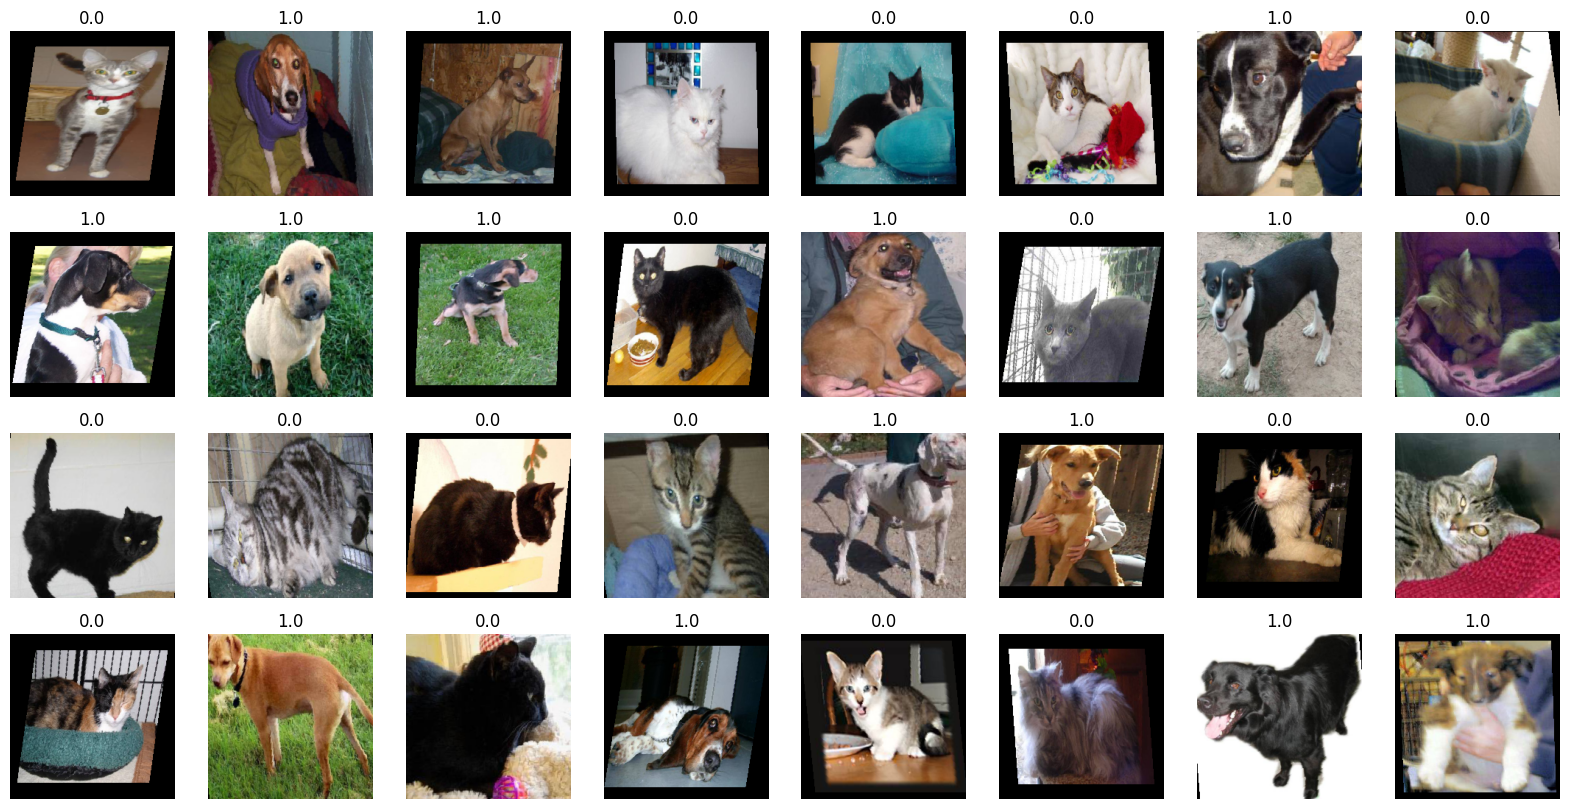

In [21]:
# 랜덤하게 이미지를 출력
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20,10)) # 4행 8열

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0)) # permute(): index로 순서를 변경하는 함수.
  ax.axis('off')

In [ ]:
# resnet50 모델 사용 # 가중치로 IMAGENET1K_V1을 미리 학습한 후 GPU로 보내겠다는 의미.
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)
# model = models.resnet50(pretrained=True).to(device) # train을 미리 하겠다.(전이학습을 하겠다)는 의미로 동일하게 사용되므로 숙지. False는 반대를 의미.

In [ ]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터를 업데이트 하지 않음.

model.fc = nn.Sequential(
    nn.Linear(2048, 128), # 입력 크기가 2048이고 출력 크기가 128인 fully connected layer를 정의
    nn.ReLU(), # ReLU(Rectified Linear Unit) 활성화 함수를 적용하는 레이어. ReLU는 입력값이 0보다 작을 경우 0으로 출력하고, 0보다 큰 경우 입력값을 그대로 출력. 이를 통해 비선형성을 도입하고 신경망의 표현력을 향상.
    nn.Linear(128,1), # 두 번째 레이어로, 입력 크기가 128이고 출력 크기가 1인 fully connected layer를 정의.
    nn.Sigmoid() #  Sigmoid 활성화 함수를 적용하는 레이어. Sigmoid 함수는 입력값을 0과 1 사이의 값으로 압축하여 이진 분류 문제에서 확률값을 제공합니다. 출력값을 0과 1 사이로 제한하여 이진 분류 결과를 나타냄.
).to(device)

print(model)

In [24]:
# 학습: fc부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train', 'validation']:
    if phase == 'train':
      model.train() # model.train() 실행 시 메모리에 optimizer가
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)
      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred>=0.5).float()
      acc = (y_batch ==y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}:Epoch{epoch+1:4d}/{epochs}, Loss:{avg_loss:.4f}, Accuracy:{avg_acc:.2f}%')

train     :Epoch   1/10, Loss:0.1366, Accuracy:94.61%
validation:Epoch   1/10, Loss:0.0724, Accuracy:97.07%
train     :Epoch   2/10, Loss:0.0925, Accuracy:96.51%
validation:Epoch   2/10, Loss:0.0443, Accuracy:98.34%
train     :Epoch   3/10, Loss:0.0773, Accuracy:96.98%
validation:Epoch   3/10, Loss:0.0725, Accuracy:96.90%
train     :Epoch   4/10, Loss:0.0743, Accuracy:96.99%
validation:Epoch   4/10, Loss:0.0407, Accuracy:98.93%
train     :Epoch   5/10, Loss:0.0770, Accuracy:97.04%
validation:Epoch   5/10, Loss:0.0388, Accuracy:98.73%
train     :Epoch   6/10, Loss:0.0712, Accuracy:97.14%
validation:Epoch   6/10, Loss:0.0569, Accuracy:97.80%
train     :Epoch   7/10, Loss:0.0767, Accuracy:97.04%
validation:Epoch   7/10, Loss:0.0657, Accuracy:97.36%
train     :Epoch   8/10, Loss:0.0637, Accuracy:97.42%
validation:Epoch   8/10, Loss:0.0373, Accuracy:98.78%
train     :Epoch   9/10, Loss:0.0623, Accuracy:97.45%
validation:Epoch   9/10, Loss:0.0794, Accuracy:96.60%
train     :Epoch  10/10, Los

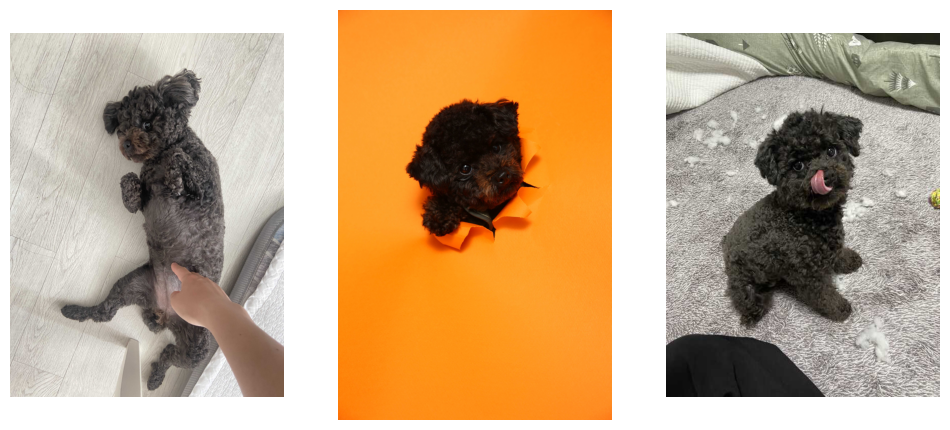

In [34]:
# 테스트 # 모델을 사용하여 주어진 두 개의 이미지에 대한 예측을 수행하고, 예측 결과와 정확도를 출력하는 기능을 구현한 예
from PIL import Image

# validation의 이미지 오픈
img1 = Image.open('/content/kong1.jpg')
img2 = Image.open('/content/kong2.jpg')
img3 = Image.open('/content/kong3.jpg')

fig, axes = plt.subplots(1,3,figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
axes[2].imshow(img3)
axes[2].axis('off')
plt.show()

In [35]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
img3_input = data_transforms['validation'](img3)

# 위에서 resize한 224*224와 tensor형태로 validation을 설정한 부분
print(img1_input.shape)
print(img2_input.shape)
print(img3_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [36]:
test_batch = torch.stack([img1_input, img2_input, img3_input]) # stack(): 붙여주는 함수
test_batch = test_batch.to(device)
test_batch.shape # img 2개가 붙어 [2,3,224,224]로 변경됨.

torch.Size([3, 3, 224, 224])

In [37]:
# 예측
y_pred = model(test_batch)
y_pred

tensor([[0.0974],
        [0.7150],
        [0.9604]], device='cuda:0', grad_fn=<SigmoidBackward0>)

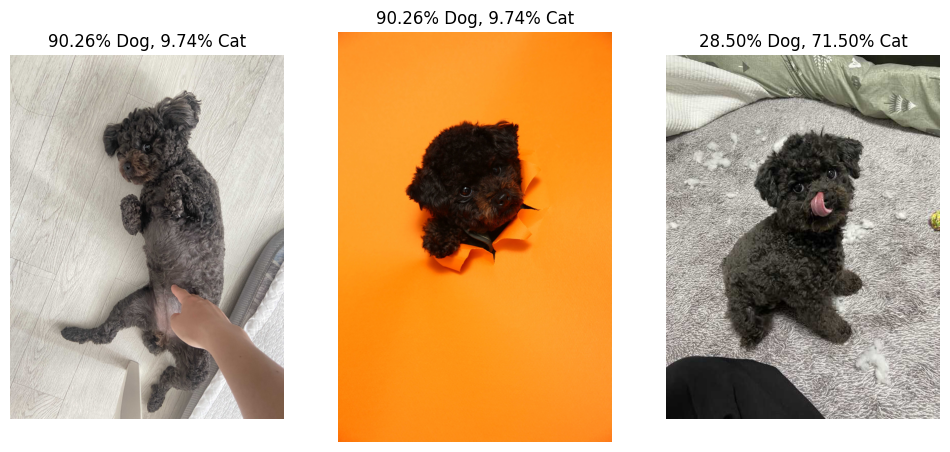

In [40]:
# 이미지 표시
fig, axes = plt.subplots(1,3,figsize=(12,6))

axes[0].set_title(f'{(1-y_pred[0,0])*100:.2f}% Dog, {y_pred[0,0]*100:.2f}% Cat')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[0,0])*100:.2f}% Dog, {y_pred[0,0]*100:.2f}% Cat')
axes[1].imshow(img2)
axes[1].axis('off')
axes[2].set_title(f'{(1-y_pred[1,0])*100:.2f}% Dog, {y_pred[1,0]*100:.2f}% Cat')
axes[2].imshow(img3)
axes[2].axis('off')
plt.show()